<a href="https://colab.research.google.com/github/antcc/proyecto-vc/blob/master/yolov3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###### *Fuente: https://github.com/antcc/proyecto-vc*
# Detección de caras con YOLOv3
Utilizaremos la base de datos [WIDERFACE](http://shuoyang1213.me/WIDERFACE/), que consta de 12881 imágenes de entrenamiento y 3220 imágenes de validación, todas anotadas con los valores de *ground truth* de las *bounding boxes*.

## Preliminares
Montamos nuestro *drive* y establecemos el directorio de trabajo. Debemos tener los siguientes archivos disponibles en el mismo:

* Una carpeta **yolo** con los ficheros de código disponibles en el repositorio, respetando la estructura presente en el mismo.
* Una carpeta llamada **widerface** que contenga a su vez 4 subcarpetas:
  * **train**: contiene las imágenes de entrenamiento.
  * **train_annot**: contiene las anotaciones de las imágenes de entrenamiento en formato VOC.
  * **valid**: contiene las imágenes de validación.
  * **valid_annot**: contiene las anotaciones de las imágenes de validación en formato VOC.
* Un archivo *config.json* que defina el entorno de configuración, similar al disponible en el respositorio.
* Una carpeta **models** donde se guardarán los modelos entrenados. Debe contener inicialmente un archivo *backend.h5* con pesos preentrenados en la red concreta que se ha implementado. Por ejemplo, unos pesos preentrenados en la base de datos COCO pueden obtenerse [aquí](https://s3-ap-southeast-1.amazonaws.com/deeplearning-mat/backend.h5).

Durante el entrenamiento se crearán automáticamente archivos auxiliares en el directorio de trabajo.

*Nota:* las anotaciones en formato VOC pueden obtenerse a partir de las originales empleando el script `yolo/utils/convert_annot.py`.





In [0]:
%tensorflow_version 1.x
import sys 
import os
import json
from google.colab import drive

# Directorio de trabajo
drive.mount("/content/drive", force_remount = True)
DIR = "/content/drive/My Drive/vc/" 
sys.path.append(os.path.abspath(DIR))
model_loaded = False

# Archivo de configuración
config_path = DIR + "config.json"
with open(config_path) as config_buffer:
    config = json.loads(config_buffer.read())

Definimos también una serie de funciones auxiliares para trabajar con imágenes.

In [0]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def norm(im):
    """Normaliza una imagen de números reales a [0,1]"""

    return cv2.normalize(im, None, 0.0, 1.0, cv2.NORM_MINMAX)

def read_im(filename, color_flag = 1):
    """Devuelve una imagen de números reales adecuadamente leída en grises o en color.
        - filename: ruta de la imagen.
        - color_flag: indica si es en color (1) o en grises (0)."""

    try:
        im = cv2.imread(filename, color_flag)
        if len(im.shape) == 3:
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    except:
        print("Error: no se ha podido cargar la imagen " + filename)
        quit()

    return im.astype(np.double)

def print_im(im, title = "", show = True, tam = (9, 9)):
    """Muestra una imagen cualquiera normalizada.
        - im: imagen a mostrar.
        - show: indica si queremos mostrar la imagen inmediatamente.
        - tam = (width, height): tamaño del plot."""

    show_title = len(title) > 0

    if show:
        fig = plt.figure(figsize = tam)

    im = norm(im)  # Normalizamos a [0,1]
    plt.imshow(im, interpolation = None, cmap = 'gray')
    plt.xticks([]), plt.yticks([])

    if show:
        if show_title:
            plt.title(title)
        plt.show() 

def print_multiple_im(vim, titles = "", ncols = 2, tam = (9, 9)):
    """Muestra una sucesión de imágenes en la misma ventana, eventualmente con sus títulos.
        - vim: sucesión de imágenes a mostrar.
        - titles: o bien vacío o bien una sucesión de títulos del mismo tamaño que vim.
        - ncols: número de columnas del multiplot.
        - tam = (width, height): tamaño del multiplot."""

    show_title = len(titles) > 0

    nrows = len(vim) // ncols + (0 if len(vim) % ncols == 0 else 1)
    plt.figure(figsize = tam)

    for i in range(len(vim)):
        plt.subplot(nrows, ncols, i + 1)
        if show_title:
            plt.title(titles[i])
        print_im(vim[i], title = "", show = False)

    plt.show()

## Entrenamiento
Creamos un modelo de la red YOLOv3, que entrenamos con los datos de entrenamiento. En el archivo de configuración, los parámetros de entrenamiento más destacables son:

* *min_input_size* y *max_input_size*: controlan el rango en el que serán redimensionadas las imágenes de entrenamiento. Deben ser múltiplos de 32.
* *input_size*: controla el tamaño de entrada de las imágenes de validación. Debe ser múltiplo de 32.
* *batch_size* y *learning_rate*: Tamaño de cada *batch* y *learning rate* inicial del optimizador Adam.
* *nb_epochs* y *warmup_epochs*: establecen el número de épocas de entrenamiento normales y el número de épocas de entrenamiento iniciales en las que se fuerza a que las *bounding boxes* coincidan con los *anchors*. En total se entranará durante un número de épocas igual a la suma de estos parámetros.
* *saved_weights_name*: indica la ruta en la que se guardará el modelo entrenado en formato HDF5.

Disponemos opcionalmente de un *callback* de *early stopping* que detiene el entrenamiento si la función de pérdida no mejora en 10 épocas. También tenemos otro *callback* (activado por defecto) que reduce el *learning rate* en un orden de magnitud si la pérdida no mejora en 2 épocas.

El archivo con el modelo entrenado puede usarse para renaudar el entrenamiento (cargándolo con `load_weights`) o para realizar predicciones (cargándolo con `load_model`). 

In [0]:
import pickle
from keras.models import load_model
from yolo.train import create_training_instances, create_model, create_callbacks
from yolo.generator import BatchGenerator
from yolo.utils.utils import normalize

def _train(epochs, fine_tune = False, early_stop = False):
    ###############################
    #   Leemos anotaciones
    ###############################
    train_ints, _, labels, max_box_per_image = create_training_instances(
        config['train']['train_annot_folder'],
        config['train']['train_image_folder'],
        config['train']['cache_name'],
        config['valid']['valid_annot_folder'],
        config['valid']['valid_image_folder'],
        config['valid']['cache_name'],
        config['model']['labels']
    )
    print('\nTraining on: \t' + str(labels) + '\n')

    ##################################
    #   Creamos generador de imágenes
    ##################################
    train_generator = BatchGenerator(
        instances           = train_ints,
        anchors             = config['model']['anchors'],
        labels              = labels,
        downsample          = 32, # ratio between network input's size and network output's size, 32 for YOLOv3
        max_box_per_image   = max_box_per_image,
        batch_size          = config['train']['batch_size'],
        min_net_size        = config['model']['min_input_size'],
        max_net_size        = config['model']['max_input_size'],
        shuffle             = True,
        jitter              = 0.3,
        norm                = normalize
    )

    ###############################
    #   Creamos el modelo
    ###############################
    if os.path.exists(config['train']['saved_weights_name']):
        config['train']['warmup_epochs'] = 0
    warmup_batches = config['train']['warmup_epochs'] * (config['train']['train_times']*len(train_generator))

    os.environ['CUDA_VISIBLE_DEVICES'] = config['train']['gpus']
    multi_gpu = len(config['train']['gpus'].split(','))

    train_model, infer_model = create_model(
        nb_class            = len(labels),
        anchors             = config['model']['anchors'],
        max_box_per_image   = max_box_per_image,
        max_grid            = [config['model']['max_input_size'], config['model']['max_input_size']],
        batch_size          = config['train']['batch_size'],
        warmup_batches      = warmup_batches,
        ignore_thresh       = config['train']['ignore_thresh'],
        multi_gpu           = multi_gpu,
        saved_weights_name  = config['train']['saved_weights_name'],
        lr                  = config['train']['learning_rate'],
        grid_scales         = config['train']['grid_scales'],
        obj_scale           = config['train']['obj_scale'],
        noobj_scale         = config['train']['noobj_scale'],
        xywh_scale          = config['train']['xywh_scale'],
        class_scale         = config['train']['class_scale'],
        backend_path        = DIR + "models/backend.h5",
        fine_tune           = fine_tune
    )

    ################################
    #   Comenzamos el entrenamiento
    ################################
    callbacks = create_callbacks(config['train']['saved_weights_name'], config['train']['tensorboard_dir'], infer_model)

    if not early_stop:
      callbacks = callbacks[1:]

    hist = train_model.fit_generator(
        generator        = train_generator,
        steps_per_epoch  = len(train_generator) * config['train']['train_times'],
        epochs           = epochs + config['train']['warmup_epochs'],
        verbose          = 2 if config['train']['debug'] else 1,
        callbacks        = callbacks,
        workers          = 4,
        max_queue_size   = 8
    )

    model_loaded = False

    print("\nTraining completed. Saved training history.")
    with open(config['train']['tensorboard_dir'] + "train_hist", 'wb') as f:
        pickle.dump(hist, f)

## Evaluación

Evaluamos el modelo obtenido en el conjunto de validación. La métrica de evaluación utilizada es la precisión media o *mAP* tal y como se evalúa en el [*COCO Challenge*](http://cocodataset.org/#detection-eval) desde 2017. La media se toma variando en 10 umbrales distintos de IoU: 0.5, 0.6, 0.65, ..., 0.95. Tras finalizar, se guardan las *bounding boxes* detectadas para cada imagen en el archivo definido en la variable *valid_result* del archivo de configuración. Se utiliza el formato definido [aquí](https://competitions.codalab.org/competitions/20146#learn_the_details-overview). Es posible crear únicamente el archivo de *valid_result* sin calcular las métricas de precisión.

In [0]:
from yolo.evaluate import evaluate_coco, predict_boxes
from yolo.generator import BatchGenerator
from yolo.voc import parse_voc_annotation
from yolo.utils.utils import normalize
from keras.models import load_model

def _evaluate(model, calculate_ap = False):
    # Leemos las anotaciones
    valid_ints, labels = parse_voc_annotation(
        config['valid']['valid_annot_folder'],
        config['valid']['valid_image_folder'],
        config['valid']['cache_name'],
        config['model']['labels']
    )

    labels = labels.keys() if len(config['model']['labels']) == 0 else config['model']['labels']
    labels = sorted(labels)

    # Creamos el generador de imágenes de validación
    valid_generator = BatchGenerator(
        instances           = valid_ints,
        anchors             = config['model']['anchors'],
        labels              = labels,
        downsample          = 32,
        max_box_per_image   = 0,
        batch_size          = config['train']['batch_size'],
        min_net_size        = config['model']['min_input_size'],
        max_net_size        = config['model']['max_input_size'],
        shuffle             = True,
        jitter              = 0.0,
        norm                = normalize
    )

    # Realizamos predicciones y guardamos resultados en fichero
    detections, annotations = predict_boxes(
        model,
        valid_generator,
        obj_thresh = 0.5,
        nms_thresh = 0.5,
        net_h=config['model']['input_size'],
        net_w=config['model']['input_size'],
        save_path = config['valid']['valid_result'])

    if calculate_ap:
        # Calculamos las métricas de evaluación   
        m_ap, ap = evaluate_coco(
            model,
            valid_generator,
            detections,
            annotations)

        # Imprimimos el resultado
        print('mAP@.5:.05:.95: {:.4f}'.format(m_ap[0]))
        print('AP@0.5: {:.4f}'.format(ap[0]))

## Detección

Definimos funciones para utilizar nuestro modelo como detector de caras tanto en imágenes como en vídeos. 

En el primer caso se muestra la imagen con las caras detectadas, y opcionalmente se muestra la posición real de las caras según las anotaciones de *ground truth*.

En el segundo caso, partiendo de un vídeo de entrada se construye un nuevo vídeo donde aparecen las *bounding boxes* detectadas en cada frame, de forma continua.

In [0]:
from yolo.utils.bbox import draw_boxes, BoundBox
from keras.models import load_model
from yolo.utils.utils import get_yolo_boxes
from yolo.voc import parse_single_annot
from tqdm import tqdm

def _detect_one(model, annot, img_dir, show = True, show_ground_truth = False):
    # Analizamos la anotación
    im_inst = parse_single_annot(annot, img_dir) 

    # Leemos la imagen
    im = read_im(im_inst['filename'])

    # Ground truth
    ground_boxes = [BoundBox(obj['xmin'], obj['ymin'], obj['xmax'], obj['ymax']) 
                       for obj in im_inst['object']]

    # Predecimos las bounding boxes     
    pred_boxes = get_yolo_boxes(
        model, 
        images = [im],
        net_h = config['model']['input_size'], 
        net_w = config['model']['input_size'], 
        anchors = config['model']['anchors'],
        obj_thresh = 0.5, 
        nms_thresh = 0.5)[0]
  
    # Dibujamos las bounding boxes
    im_boxes = draw_boxes(im, pred_boxes, color = (0, 255, 25))

    if show_ground_truth:
        im_boxes = draw_boxes(im, ground_boxes, show_score = False, color = (255, 0, 25))

    # Mostramos la imagen
    if show:
        print_im(im_boxes)

    return im_boxes

def _detect_video(model, filein, fileout):
    # Abrimos el vídeo
    video_reader = cv2.VideoCapture(filein)

    # Recolectamos información del vídeo
    frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_h = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_w = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    fps = video_reader.get(cv2.CAP_PROP_FPS)

    # Creamos vídeo de salida
    video_writer = cv2.VideoWriter(
        fileout,
        cv2.VideoWriter_fourcc(*'MPEG'), 
        fps, 
        (frame_w, frame_h))
    
    batch_size  = 1
    images      = []
    for i in tqdm(range(frames)):
        # Leemos frames del vídeo
        _, image = video_reader.read()
        images += [image]

        if (i%batch_size == 0) or (i == (frames-1) and len(images) > 0):
            # Predecimos bounding boxes
            batch_boxes = get_yolo_boxes(
                model, 
                images, 
                config['model']['input_size'], 
                config['model']['input_size'], 
                config['model']['anchors'], 
                obj_thresh = 0.6, 
                nms_thresh = 0.4)

            for i in range(len(images)):
                # Dibujamos bounding boxes
                draw_boxes(images[i], batch_boxes[i], show_score = False)   

                # Escribimos imágenes en el vídeo de salida
                video_writer.write(images[i]) 

        images = []

    # Liberamos recursos
    video_reader.release()
    video_writer.release()

## Prueba de entrenamiento y evaluación

Probamos ahora a entrenar y evaluar el modelo con la configuración dada.

In [0]:
# Definimos los parámetros de entrenamiento
EARLY_STOP = False
FINE_TUNE = False
EPOCHS = config['train']['nb_epochs']

# Entrenamos el modelo
_train(EPOCHS, FINE_TUNE, EARLY_STOP)

In [0]:
# Cargamos el modelo
if not model_loaded:
    yolov3 = load_model(config['valid']['valid_model'])
    model_loaded = True

# Evaluamos el modelo
_evaluate(yolov3)
print("\nEvaluation finished.")

## Prueba de detección

Detectamos ahora caras en una imagen (con y sin las *bounding boxes* verdaderas) y probamos a realizar detección en vídeo.

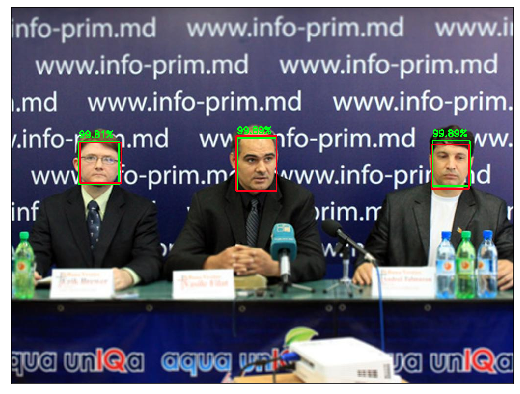

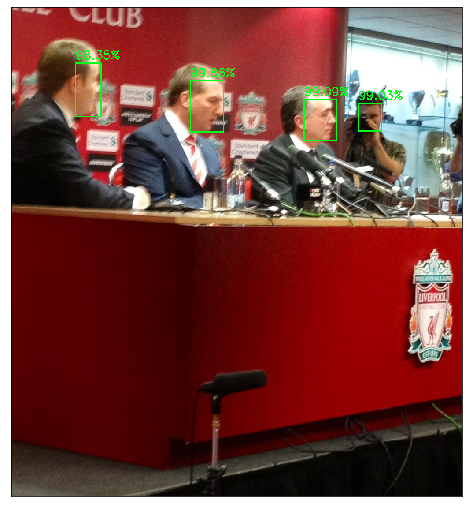

In [30]:
# Cargamos el modelo
if not model_loaded:
    yolov3 = load_model(config['valid']['valid_model'])
    model_loaded = True

# Definimos un par de imágenes de prueba
annot1 = config['valid']['valid_annot_folder'] \
    + "9_Press_Conference_Press_Conference_9_74.xml"
annot2 = config['valid']['valid_annot_folder'] \
    + "9_Press_Conference_Press_Conference_9_89.xml"

# Detectamos caras en las imágenes de prueba
_ = _detect_one(yolov3, annot1, config['valid']['valid_image_folder'], show_ground_truth = True)
_ = _detect_one(yolov3, annot2, config['valid']['valid_image_folder'], show_ground_truth = False)

# Detectamos caras en un vídeo
#_detect_video(yolov3, DIR + "test.mp4", DIR + "test_out.mp4")